<a href="https://colab.research.google.com/github/lauravj99/Deep_Learning/blob/main/Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading and cleaning

In [1]:
# Required for google collab to run
!pip install --upgrade urllib3 requests requests_cache retry_requests openmeteo-requests kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.2/683.2 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires 

In [2]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import kagglehub
from sklearn.preprocessing import StandardScaler

# Setup the Open-Meteo API (where the weather data is imported from) client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# After cleaning the data we determined a period which contains the most data points for all streets
period_start = "2007-01-01"
period_end = "2012-12-31"

# Take selected variables from the data set ensuring that they are from the Copenhagen region
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 55.6759,
	"longitude": 12.5655,
	"start_date": period_start,
	"end_date": period_end,
	"hourly": ["temperature_2m", "rain", "snowfall", "cloud_cover", "weather_code", "wind_speed_10m", "relative_humidity_2m"],
	"timezone": "Europe/Berlin",
}
# Storing the data and parameters together
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Hourly weather data, this is done to ensure that its aligned with the other dataset since the number of cyclists is in hours
hourly = response.Hourly()

# Build the dataframe with the hourly weather data
hourly_df = pd.DataFrame({
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ),
    "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
    "rain": hourly.Variables(1).ValuesAsNumpy(),
    "snowfall": hourly.Variables(2).ValuesAsNumpy(),
    "cloud_cover": hourly.Variables(3).ValuesAsNumpy(),
    "weather_code": hourly.Variables(4).ValuesAsNumpy(),
    "wind_speed_10m": hourly.Variables(5).ValuesAsNumpy(),
    "relative_humidity_2m": hourly.Variables(6).ValuesAsNumpy()
})


# Downloading the latest version of the kaggle bike traffic data counts in Copenhagen
path = kagglehub.dataset_download("emilhvitfeldt/bike-traffic-counts-in-copenhagen")

# Build the dataframe to align the two datasets
df = pd.read_csv(path + "//total_rides.csv")

# First we change the timestamps in the following way:
# Start time: "00-01" -> 0, "13-14" -> 13, ...
# Previously it was a period and now we made it into a constant timestamp
df["hour_start"] = df["time"].str[:2].astype(int)

df = df[df["date"].between(period_start, period_end)]

# The second change ensures that the data type in both data sets is aligned by combining the date and the clock
# Combining both columns into one
df["datetime"] = pd.to_datetime(df["date"]) + pd.to_timedelta(df["hour_start"], unit="h")

# Aligning the timezones to be Europe, Copenhagen area
hourly_df = hourly_df.copy()
hourly_df["date"] = (
    hourly_df["date"]
    .dt.tz_convert("Europe/Copenhagen")
    .dt.tz_localize(None)
)
# Rename the columns date to datetime
hourly_df.rename(columns={'date': 'datetime'}, inplace=True)

# Merge both datasets
hourly_df = pd.merge(hourly_df,df , on = "datetime", how="left")

# Add in the weekday and if that day is a weekend or a weekday
hourly_df["weekday"] = hourly_df["datetime"].dt.day_name()

hourly_df["is_weekend"] = hourly_df["weekday"].isin(["Saturday", "Sunday"])

# Rename the column n  to number of cyclists
hourly_df.rename(columns={'n': 'number of cyclists'}, inplace=True)

# Count the number of data points we have for each road
# There's an imabalance between the number of data pointsfor some roads
# hence those with fewer data than the established threshold will be removed from the dataset
counts = hourly_df["road_name"].value_counts()
removed_roads = counts[counts < 15000].index
# The roads removed can be seen below
print("The roads that have been removed from the dataset are: ", removed_roads)

hourly_df = hourly_df[~hourly_df["road_name"].isin(removed_roads)]

# Remove the na values
hourly_df = hourly_df[hourly_df["road_name"].notna()]

# Split the dataset into train, test and validation,
# We have 6 years of data in total, hence we make the following split:
# Train: 4 years of data (2007-2010)
# Test: 1 year of data (2011)
# Validation: 1 year of data (2012)
hourly_df_train = hourly_df[hourly_df["date"].between('2007-01-01', '2010-12-31')]

hourly_df_test = hourly_df[hourly_df["date"].between('2011-01-01', '2011-12-31')]

hourly_df_valid = hourly_df[hourly_df["date"].between('2012-01-01', '2012-12-31')]

# Remove duplicated columns
hourly_df_train.drop(columns=['date', 'time', 'hour_start'], inplace=True)
hourly_df_test.drop(columns=['date', 'time', 'hour_start'], inplace=True)
hourly_df_valid.drop(columns=['date', 'time', 'hour_start'], inplace=True)

# Ensure NA values are removed
hourly_df_train = hourly_df_train[hourly_df_train["number of cyclists"].notna()]
hourly_df_valid = hourly_df_valid[hourly_df_valid["number of cyclists"].notna()]
hourly_df_test = hourly_df_test[hourly_df_test["number of cyclists"].notna()]

# Define full as training, test and validation combined
full = pd.concat([hourly_df_train, hourly_df_valid, hourly_df_test], axis=0)

# Give each road name and weekday an id
road_id = {name: i for i, name in enumerate(full["road_name"].unique())}
weekday_id = {name: i for i, name in enumerate(full["weekday"].unique())}

# Include these ids in the dataset
for df in [hourly_df_train, hourly_df_valid, hourly_df_test]:
  df["road_id"] = df["road_name"].map(road_id)
  df["weekday_id"] = df["weekday"].map(weekday_id)
  df["is_weekend"] = df["is_weekend"].astype(int)

# List numerical input features the model will use such that they can be extracted
numeric_cols = [
    "temperature_2m",
    "rain",
    "snowfall",
    "cloud_cover",
    "wind_speed_10m",
    "relative_humidity_2m",
    "is_weekend",
]

# Normalize the data for both the weather and bicycle counts data
y_scaler = StandardScaler()
hourly_df_train["number of cyclists"] = y_scaler.fit_transform(hourly_df_train[["number of cyclists"]])
hourly_df_valid["number of cyclists"] = y_scaler.transform(hourly_df_valid[["number of cyclists"]])
hourly_df_test["number of cyclists"] = y_scaler.transform(hourly_df_test[["number of cyclists"]])

scaler = StandardScaler()
hourly_df_train[numeric_cols] = scaler.fit_transform(hourly_df_train[numeric_cols])
hourly_df_valid[numeric_cols] = scaler.transform(hourly_df_valid[numeric_cols])
hourly_df_test[numeric_cols] = scaler.transform(hourly_df_test[numeric_cols])


Using Colab cache for faster access to the 'bike-traffic-counts-in-copenhagen' dataset.
The roads that have been removed from the dataset are:  Index(['Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)', 'Englandsvej'], dtype='object', name='road_name')


/tmp/ipython-input-3565863216.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df_train.drop(columns=['date', 'time', 'hour_start'], inplace=True)
/tmp/ipython-input-3565863216.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df_test.drop(columns=['date', 'time', 'hour_start'], inplace=True)
/tmp/ipython-input-3565863216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df_valid.drop(columns=['date', 

# Initializing dataloaders

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import math
import numpy as np

# Set the sliding windows for 168 hours (7 days)
T = 168

def build_sequences_for_df(df, T):
    """
    - Build sequences from the dataset using sliding windows
     Parameters:
    - df: dataframe
    - T: int, sliding windows
    Returns:
    - X_road: torch.Tensor, Road ID sequence
    - X_weekday: torch.Tensor, Weekday ID sequence
    - X_weather: torch.Tensor, Weather code sequence
    - X_num: torch.Tensor, numeric feature sequences (temp, wind...)
    - y: torch.Tensor, target (number of cyclists)
    """
    # Set the variables as empty list
    X_road, X_weekday, X_weather, X_num, y = [], [], [], [], []

    # Sort dataframe
    df = df.sort_values(["road_id", "datetime"])

    # Loop through each road independently to avoid mixing data from different roads
    for road_id_value, group in df.groupby("road_id"):
        group = group.reset_index(drop=True)
        # Extract arrays for all the features we want to use
        roads = group["road_id"].values
        weekdays = group["weekday_id"].values
        weather_codes = group["weather_code"].astype(int).values
        nums = group[numeric_cols].values
        targets = group["number of cyclists"].values

        # If a road has fewr that T observations we skip it, since its not possible to form a full window
        if len(group) <= T:
            continue

        # Slide a window of length T across the road's time series
        # For each window store input sequence and target value at time i
        for i in range(T, len(group)):
            X_road.append(roads[i-T:i])
            X_weekday.append(weekdays[i-T:i])
            X_weather.append(weather_codes[i-T:i])
            X_num.append(nums[i-T:i])
            y.append(targets[i])

    # Convert to pytorch tensors
    X_road = torch.tensor(np.array(X_road), dtype=torch.long)
    X_weekday = torch.tensor(np.array(X_weekday), dtype=torch.long)
    X_weather = torch.tensor(np.array(X_weather), dtype=torch.long)
    X_num = torch.tensor(np.array(X_num), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)

    return X_road, X_weekday, X_weather, X_num, y

# Build tensors for each split (test, train and validation)
train_tensors = build_sequences_for_df(hourly_df_train, T)
valid_tensors = build_sequences_for_df(hourly_df_valid, T)
test_tensors  = build_sequences_for_df(hourly_df_test,  T)

# Wrap the tensors into TensorDataset objects
train_ds = TensorDataset(*train_tensors)
valid_ds = TensorDataset(*valid_tensors)
test_ds = TensorDataset(*test_tensors)

# Selected batch size to be 64 to ensure training stability and performance
batch_size = 64

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = batch_size, shuffle = False)
test_loader  = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

# Model 1
### (1 Embedding layer, 2 LSTM layers, 2 dense layers and 1 output layer)



In [4]:
import torch.nn.functional as F

class DeepLSTMModel(nn.Module):
    def __init__(
        self,
        n_roads,
        n_weekdays,
        # Total number of unique weather categories
        n_weather_codes,
        # Number of continuous weather features
        num_numeric_features,
        # Embedding size for road, weekday and weather
        road_emb_dim=8,
        weekday_emb_dim=4,
        weather_emb_dim=4,
        # Size for first and second layer of LSTM
        lstm_hidden1=128,
        lstm_hidden2=64,
        # dropout default value
        dropout=0.2,
    ):
        # Initialize
        super().__init__()

        # Embeddings
        self.road_emb = nn.Embedding(n_roads, road_emb_dim)
        self.weekday_emb = nn.Embedding(n_weekdays, weekday_emb_dim)
        self.weather_emb = nn.Embedding(n_weather_codes, weather_emb_dim)

        # The dimension of the input to the LSTM is computed at each time step
        lstm_input_dim = num_numeric_features + road_emb_dim + weekday_emb_dim + weather_emb_dim

        # LSTM layers
        self.lstm1 = nn.LSTM(lstm_input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)

        # Dense layers
        self.fc1 = nn.Linear(lstm_hidden2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)

        # Dropout layer (NOW using the hyperparameter)
        self.dropout = nn.Dropout(dropout)


    def forward(self, road_seq, weekday_seq, weather_seq, num_feats):
        """
        - Forward pass through the model

        Parameters:
        - road_seq: torch.Tensor, Road ID sequence
        - weekday_seq: torch.Tensor, Weekday Ids sequence
        - weather_seq: torch.Tensor, Weather code sequence
        - num_feats: torch.Tensor, numeric feature vector per time step

        Returns:
        - torch.Tensor, predicted number of cyclists at each time step
        """

        # Convert to embeddings
        r = self.road_emb(road_seq)
        w = self.weekday_emb(weekday_seq)
        wc = self.weather_emb(weather_seq)

        # Concatenate all inputs along the feature dimension
        x = torch.cat([num_feats, r, w, wc], dim=-1)

        # First pass the full sequence through the first layer of the LSTM
        # Then pass the output from this through the second layer
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        # Take last output of the sequence
        # Apply droupout, dense layer, Relu
        x = x[:, -1, :]
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # Final prediction
        return self.out(x).squeeze(-1)

# Training functions

In [5]:
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_epoch(loader, model, criterion, optimizer):
    """
    Executes training or validation epoch over the DataLoader

    Parameters:
    - loader: DataLoader
    - training: bool, True if training, False if validation

    Returns:
    -  float, average over the MSE loss for the epoch
    """
    training = optimizer is not None

    # Set the model mode to enable or disable dropout and batchnorm
    if training:
        model.train()
    else:
        model.eval()

    # Total loss for the epoch and count number of samples processed
    epoch_loss = 0.0
    n_samples = 0

    # Enable the gradients only during training
    with torch.set_grad_enabled(training):
        # Iterate over the batches from the DataLoader and move the batch tensors to the device
        for road_seq, weekday_seq, weather_seq, num_feats, target in loader:
            road_seq = road_seq.to(device)
            weekday_seq = weekday_seq.to(device)
            weather_seq = weather_seq.to(device)
            num_feats = num_feats.to(device)
            target = target.to(device)
            # Reset the gradients only during training
            if training:
                optimizer.zero_grad()
            # Forward pass to make prediction
            pred = model(road_seq, weekday_seq, weather_seq, num_feats)
            loss = criterion(pred, target)

            # Update
            batch_size = target.size(0)
            epoch_loss += loss.item() * batch_size
            n_samples += batch_size

            # Backpropagation if training
            if training:
                loss.backward()
                optimizer.step()
    # Return average per sample
    return epoch_loss / n_samples

def train_model(model, train_loader, valid_loader, num_epochs=20, lr=0.001, weight_decay = 0.0):

    model = model.to(device)

    # Use MSE loss since we are predicting cyclist counts
    criterion = nn.MSELoss()

    # Use ADAM optimizer since it has adaptive learning rate, default for LSTM modelling
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

    best_valid = float("inf")
    best_state = None
    # Making history to keep track of train loss and valid loss
    history = {"train": [], "valid":[]}

    # Running the training
    for epoch in range(num_epochs):
        train_loss = run_epoch(train_loader, model, criterion, optimizer)
        valid_loss = run_epoch(valid_loader, model, criterion, optimizer=None)

        # Stores validation and train loss
        history["train"].append(train_loss)
        history["valid"].append(valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train MSE:{train_loss:.3f} "
              f"Valid MSE:{valid_loss:.3f}")

        # Saves the best model
        if valid_loss < best_valid:
            best_valid = valid_loss
            best_state = copy.deepcopy(model.state_dict())
    return best_valid, best_state, history

# Number of unique roads
n_roads = len(road_id)
# Number of weekdays
n_weekdays = len(weekday_id)
# Number of weather codes
n_weather_codes = int(full["weather_code"].max()) + 1
# Number of numerical features
num_numeric_features = len(numeric_cols)


# Model 2
### (2 CNN layers, 2 BiLSTM layers, 1 dense layer and 1 output layer)

In [6]:
# Building the second model

class ConvBiLSTM(nn.Module):
    def __init__(
        self,
        n_roads,
        n_weekdays,
        n_weather_codes,
        num_numeric_features,
        road_emb_dim=8,
        weekday_emb_dim=4,
        weather_emb_dim=4,
        # Output layers for each CNN layer
        conv_channels=[64, 64],
        conv_kernel=3,
        lstm_hidden=64,
        lstm_layers=1,
        dropout=0.2
    ):
        super().__init__()

        # Embeddings
        self.road_emb = nn.Embedding(n_roads, road_emb_dim)
        self.weekday_emb = nn.Embedding(n_weekdays, weekday_emb_dim)
        self.weather_emb = nn.Embedding(n_weather_codes, weather_emb_dim)

        # Total feature dimension per time step
        self.feature_dim = road_emb_dim + weekday_emb_dim+ weather_emb_dim + num_numeric_features

        # CNN layers:
        # Conv -> ReLU -> Dropout
        convs = []
        # First conv input channels
        in_ch = self.feature_dim
        # For each channel size in conv_channels we add a Conv1d layer followed
        # by Relu and Dropout.
        # After each block in_ch is updated so the next convolution receives the
        # the correct number of input channels.
        for out_ch in conv_channels:
            convs.append(nn.Conv1d(in_ch, out_ch, conv_kernel, padding=conv_kernel//2))
            convs.append(nn.ReLU())
            convs.append(nn.Dropout(dropout))
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)

        # BiLSTM
        # Add a bidirectional LSTM to capture both past and future temporal
        # dependencies in the feature sequence. The input size is equal to the
        # number of output channels from the CNN.
        self.bilstm = nn.LSTM(
            input_size=conv_channels[-1],
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        # MLP head
        # Used to map the combined forward and backward LSTM output into the
        # final regression prediction.
        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, road_seq, weekday_seq, weather_seq, num_feats):

        # Embeddings:
        r = self.road_emb(road_seq)
        w = self.weekday_emb(weekday_seq)
        wc = self.weather_emb(weather_seq)

        # Concatenate embeddings and numeric features along the feature dimension
        x = torch.cat([num_feats, r, w, wc], dim=-1)

        # Because of expected size of CNN permutation is done
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)

        # BiLSTM is applied to the CNN output sequence
        x,_ = self.bilstm(x)
        x = x[:, -1, :]
        x = self.mlp(x)

        return x.squeeze(-1)


# Tuning hyperparameters model 1

In [ ]:
import itertools

# We run a grid search to compare different hyperparameter combinations.
# This helps us identify the settings that give the lowest validation MSE.
# The chosen ranges reflect typical values for LSTM models and allow us to test
# different model sizes, regularization levels, and learning rates.
results_model1 = []

# Candidate hyperparameters to test
# First LSTM layer size
lstm_hidden1_list = [64, 128]
# Second LSTM layer size
lstm_hidden2_list = [32, 64]
# Dropout size
dropout_list = [0.2, 0.4]
# Learning rate
lr_list = [0.001, 0.0003, 0.0001]

# Try all combinations of the above hyperparameters by taking the cartesian product of the four vectors
for h1, h2, dr, lr in itertools.product(lstm_hidden1_list, lstm_hidden2_list, dropout_list, lr_list):
  print(f"Testing model 1: h1={h1}, h2={h2}, dropout={dr}, lr={lr}")
  # Build a model with the current hyperparameter combination
  model1 = DeepLSTMModel(
      n_roads = n_roads,
      n_weekdays = n_weekdays,
      n_weather_codes = n_weather_codes,
      num_numeric_features = num_numeric_features,
      lstm_hidden1 = h1,
      lstm_hidden2 = h2,
      dropout=dr,
      ).to(device)

  # Train the model and track the best validation MSE and model state
  best_val, best_state, history = train_model(
      model1,
      train_loader,
      valid_loader,
      num_epochs = 15,
      lr=lr,
      weight_decay=0.0,
      )

  # Store results
  results_model1.append({
    "lstm_hidden1": h1,
    "lstm_hidden2": h2,
    "dropout": dr,
    "lr": lr,
    "best_val_mse": best_val,
    "best_state": best_state,
    "history": history
})

# Convert results to DataFrame and sort by validation performance
df_model1 = pd.DataFrame(results_model1)
df_model1 = df_model1.sort_values("best_val_mse")
display(df_model1)

Testing model 1: h1=64, h2=32, dropout=0.2, lr=0.001
Epoch 1/15 Train MSE:0.234 Valid MSE:0.533
Epoch 2/15 Train MSE:0.116 Valid MSE:0.561
Epoch 3/15 Train MSE:0.101 Valid MSE:0.588
Epoch 4/15 Train MSE:0.089 Valid MSE:0.571
Epoch 5/15 Train MSE:0.078 Valid MSE:0.557
Epoch 6/15 Train MSE:0.062 Valid MSE:0.586
Epoch 7/15 Train MSE:0.051 Valid MSE:0.562
Epoch 8/15 Train MSE:0.045 Valid MSE:0.587
Epoch 9/15 Train MSE:0.038 Valid MSE:0.561
Epoch 10/15 Train MSE:0.036 Valid MSE:0.553
Epoch 11/15 Train MSE:0.042 Valid MSE:0.587
Epoch 12/15 Train MSE:0.031 Valid MSE:0.569
Epoch 13/15 Train MSE:0.030 Valid MSE:0.526
Epoch 14/15 Train MSE:0.030 Valid MSE:0.527
Epoch 15/15 Train MSE:0.027 Valid MSE:0.541
Testing model 1: h1=64, h2=32, dropout=0.2, lr=0.0003
Epoch 1/15 Train MSE:0.323 Valid MSE:0.598
Epoch 2/15 Train MSE:0.161 Valid MSE:0.551
Epoch 3/15 Train MSE:0.134 Valid MSE:0.542
Epoch 4/15 Train MSE:0.115 Valid MSE:0.557
Epoch 5/15 Train MSE:0.107 Valid MSE:0.537
Epoch 6/15 Train MSE:0.102 

,lstm_hidden1,lstm_hidden2,dropout,lr,best_val_mse,best_state,history
13,128,32,0.2,0.0003,0.502773,"{'road_emb.weight': [[tensor(1.7613, device='c...","{'train': [0.2964757594077646, 0.1470194216181..."
16,128,32,0.4,0.0003,0.513514,"{'road_emb.weight': [[tensor(1.4482, device='c...","{'train': [0.3014420500867637, 0.1644634283119..."
22,128,64,0.4,0.0003,0.523345,"{'road_emb.weight': [[tensor(0.1189, device='c...","{'train': [0.31166210854320714, 0.162844822944..."
15,128,32,0.4,0.0010,0.523457,"{'road_emb.weight': [[tensor(0.9264, device='c...","{'train': [0.2574001256171693, 0.1224995609660..."
1,64,32,0.2,0.0003,0.523821,"{'road_emb.weight': [[tensor(-1.5809, device='...","{'train': [0.3226641423758084, 0.1609562400089..."
17,128,32,0.4,0.0001,0.524375,"{'road_emb.weight': [[tensor(-1.5115, device='...","{'train': [0.4126099955785047, 0.2066227762207..."
3,64,32,0.4,0.0010,0.524435,"{'road_emb.weight': [[tensor(-1.2498, device='...","{'train': [0.2717052408959841, 0.1348036435917..."
18,128,64,0.2,0.0010,0.525224,"{'road_emb.weight': [[tensor(-1.0994, device='...","{'train': [0.20156966747263444, 0.105396897532..."
0,64,32,0.2,0.0010,0.526064,"{'road_emb.weight': [[tensor(-1.6391, device='...","{'train': [0.23387552996876348, 0.115677736937..."
14,128,32,0.2,0.0001,0.527494,"{'road_emb.weight': [[tensor(-0.4488, device='...","{'train': [0.3903104477846614, 0.1836690309196..."


In [ ]:
import pickle

# Save all hyperparameter search results
with open("results_model1.pkl", "wb") as f:
    pickle.dump(results_model1, f)

print("Saved result file")

# Extract the best-performing combination of hyperparameters from the sorted DataFrame
best1 = df_model1.iloc[0]

# Save the corresponding model weights for future loading/inference
torch.save(best1["best_state"], "best_model1_state.pt")

print("Saved best model states")

# Download results and best model state to local machine (Colab-specific)
from google.colab import files
files.download("results_model1.pkl")
files.download("best_model1_state.pt")

Saved result file
Saved best model states


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Tuning hyperparameters model 2

In [ ]:
# The same grid search for finding the best combination of hyperparameters is done for model 2
# This model also includes weight decay as an additional form of regularization,
# which can be relevant for CNN–LSTM architectures.


results_model2 = []

# Hyperparameter ranges included in the search
lstm_hidden_list = [64, 128]
dropout_list = [0.2, 0.3]
weight_decay_list = [0.0, 0.00001]
lr_list = [0.001, 0.0003, 0.0001]

# Evaluation of all hyperparameter combinations
for h, dr, wd, lr in itertools.product(lstm_hidden_list, dropout_list, weight_decay_list, lr_list):
  print(f"Testing model 2: h={h}, dropout={dr}, weight_decay={wd:.5f}, lr={lr}")

  # Build a ConvBiLSTM model using the current hyperparameters
  model2 = ConvBiLSTM(
      n_roads = n_roads,
      n_weekdays = n_weekdays,
      n_weather_codes = n_weather_codes,
      num_numeric_features = num_numeric_features,
      conv_channels = [64,64],
      conv_kernel = 3,
      lstm_hidden = h,
      dropout = dr,
  ).to(device)

  # Train the model and track the best validation MSE and model state
  best_val, best_state, history = train_model(
      model2,
      train_loader,
      valid_loader,
      num_epochs = 15,
      lr = lr,
      weight_decay = wd,
  )

  # Store results
  results_model2.append({
    "lstm_hidden": h,
    "dropout": dr,
    "weight_decay": wd,
    "lr": lr,
    "best_val_mse": best_val,
    "best_state": best_state,
    "history": history
})

# Convert results to DataFrame and sort by validation performance
df_model2 = pd.DataFrame(results_model2)
df_model2 = df_model2.sort_values("best_val_mse")
display(df_model2)


Testing model 2: h=64, dropout=0.2, weight_decay=0.00000, lr=0.001
Epoch 1/15 Train MSE:0.289 Valid MSE:0.549
Epoch 2/15 Train MSE:0.117 Valid MSE:0.557
Epoch 3/15 Train MSE:0.106 Valid MSE:0.537
Epoch 4/15 Train MSE:0.101 Valid MSE:0.532
Epoch 5/15 Train MSE:0.096 Valid MSE:0.543
Epoch 6/15 Train MSE:0.083 Valid MSE:0.507
Epoch 7/15 Train MSE:0.075 Valid MSE:0.558
Epoch 8/15 Train MSE:0.066 Valid MSE:0.553
Epoch 9/15 Train MSE:0.059 Valid MSE:0.536
Epoch 10/15 Train MSE:0.056 Valid MSE:0.534
Epoch 11/15 Train MSE:0.053 Valid MSE:0.555
Epoch 12/15 Train MSE:0.052 Valid MSE:0.550
Epoch 13/15 Train MSE:0.049 Valid MSE:0.548
Epoch 14/15 Train MSE:0.046 Valid MSE:0.589
Epoch 15/15 Train MSE:0.047 Valid MSE:0.532
Testing model 2: h=64, dropout=0.2, weight_decay=0.00000, lr=0.0003
Epoch 1/15 Train MSE:0.293 Valid MSE:0.574
Epoch 2/15 Train MSE:0.137 Valid MSE:0.553
Epoch 3/15 Train MSE:0.116 Valid MSE:0.566
Epoch 4/15 Train MSE:0.106 Valid MSE:0.544
Epoch 5/15 Train MSE:0.099 Valid MSE:0.548

,lstm_hidden,dropout,weight_decay,lr,best_val_mse,best_state,history
2,64,0.2,0.00000,0.0001,0.495545,"{'road_emb.weight': [[tensor(1.0491, device='c...","{'train': [0.3864130858142936, 0.1840378691108..."
14,128,0.2,0.00000,0.0001,0.497671,"{'road_emb.weight': [[tensor(-0.2548, device='...","{'train': [0.40129304613428757, 0.172563530266..."
9,64,0.3,0.00001,0.0010,0.504414,"{'road_emb.weight': [[tensor(2.1014, device='c...","{'train': [0.24332315457107334, 0.119980123272..."
0,64,0.2,0.00000,0.0010,0.506542,"{'road_emb.weight': [[tensor(-0.3695, device='...","{'train': [0.28906540001501185, 0.117082442572..."
21,128,0.3,0.00001,0.0010,0.508571,"{'road_emb.weight': [[tensor(-0.4867, device='...","{'train': [0.2986701844298521, 0.1226099483971..."
20,128,0.3,0.00000,0.0001,0.510052,"{'road_emb.weight': [[tensor(1.0277, device='c...","{'train': [0.3802898734523036, 0.1804390393138..."
8,64,0.3,0.00000,0.0001,0.510591,"{'road_emb.weight': [[tensor(-0.6534, device='...","{'train': [0.43841252274380965, 0.206189003660..."
19,128,0.3,0.00000,0.0003,0.511252,"{'road_emb.weight': [[tensor(1.1101, device='c...","{'train': [0.3035287888518993, 0.1318692603352..."
11,64,0.3,0.00001,0.0001,0.513041,"{'road_emb.weight': [[tensor(-1.3064, device='...","{'train': [0.41683955617378965, 0.209616403812..."
5,64,0.2,0.00001,0.0001,0.515309,"{'road_emb.weight': [[tensor(-0.5609, device='...","{'train': [0.4038403071645766, 0.1854636505398..."


In [ ]:
import pickle
# Imported to be able to download results from colab
from google.colab import files

# Save hyperparameter search results

with open("results_model2.pkl", "wb") as f:
    pickle.dump(results_model2, f)

print("Saved result file")

# Extract the best-performing combination of hyperparameters from the sorted DataFrame
best2 = df_model2.iloc[0]

# Save the corresponding model weights for future loading/inference
torch.save(best2["best_state"], "best_model2_state.pt")

print("Saved best model states")

# Download results and best model state to local machine
files.download("results_model2.pkl")
files.download("best_model2_state.pt")

Saved result file
Saved best model states


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loading in the results from computer

In [7]:
# Re-importing pickle and files because the previous import was not executed in this session
from google.colab import files
import pickle

# Upload the saved result and model state files from local storage
# Reloading the result files is necessary to avoid running the hyperparameter grid search
# each time Colab is reopened, since Colab sessions reset and therefore remove all saved results from the session.

# The four files (results_model1.pkl, results_model2.pkl, best_model1_state.pt and best_model2_state.pt) are uploaded from the local storage
uploaded = files.upload()

# Select device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load hyperparameter search results from both models
with open("results_model1.pkl", "rb") as f:
    results_model1 = pickle.load(f)

with open("results_model2.pkl", "rb") as f:
    results_model2 = pickle.load(f)

# Convert to DataFrames for analysis and plotting
df_model1 = pd.DataFrame(results_model1).sort_values("best_val_mse").reset_index(drop=True)
df_model2 = pd.DataFrame(results_model2).sort_values("best_val_mse").reset_index(drop=True)

print("Top 5 parameter combinations for Model 1:")
display(df_model1.head())

print("\nTop 5 parameter combinations for Model 2:")
display(df_model2.head())

# Extract the best parameter combination (lowest validation MSE) for each model
best1 = df_model1.iloc[0]
best2 = df_model2.iloc[0]

print("\nBest Model 1 hyperparameters:")
print(best1[["lstm_hidden1", "lstm_hidden2", "dropout", "lr"]])

print("\nBest Model 2 hyperparameters:")
print(best2[["lstm_hidden", "dropout", "weight_decay", "lr"]])

# Reconstructing the two models using the optimal hyperparameters found in the search
# Assumes model classes and feature dimensions are already defined in earlier cells

model1 = DeepLSTMModel(
    n_roads=n_roads,
    n_weekdays=n_weekdays,
    n_weather_codes=n_weather_codes,
    num_numeric_features=num_numeric_features,
    road_emb_dim=8,
    weekday_emb_dim=4,
    weather_emb_dim=4,
    lstm_hidden1=int(best1["lstm_hidden1"]),
    lstm_hidden2=int(best1["lstm_hidden2"]),
    dropout=float(best1["dropout"]),
).to(device)

model2 = ConvBiLSTM(
    n_roads=n_roads,
    n_weekdays=n_weekdays,
    n_weather_codes=n_weather_codes,
    num_numeric_features=num_numeric_features,
    conv_channels=[64, 64],
    conv_kernel=3,
    lstm_hidden=int(best2["lstm_hidden"]),
    dropout=float(best2["dropout"]),
).to(device)

# Load the saved model weights and attach them to the reconstructed models
state_dict1 = torch.load("best_model1_state.pt", map_location=device)
state_dict2 = torch.load("best_model2_state.pt", map_location=device)

model1.load_state_dict(state_dict1)
model2.load_state_dict(state_dict2)

print("\nBoth models have been reconstructed with their best hyperparameters and weights.")


Saving best_model1_state.pt to best_model1_state.pt
Saving best_model2_state.pt to best_model2_state.pt
Saving results_model1.pkl to results_model1.pkl
Saving results_model2.pkl to results_model2.pkl
Top 5 configurations for Model 1:


,lstm_hidden1,lstm_hidden2,dropout,lr,best_val_mse,best_state,history
0,128,32,0.2,0.0003,0.502773,"{'road_emb.weight': [[tensor(1.7613, device='c...","{'train': [0.2964757594077646, 0.1470194216181..."
1,128,32,0.4,0.0003,0.513514,"{'road_emb.weight': [[tensor(1.4482, device='c...","{'train': [0.3014420500867637, 0.1644634283119..."
2,128,64,0.4,0.0003,0.523345,"{'road_emb.weight': [[tensor(0.1189, device='c...","{'train': [0.31166210854320714, 0.162844822944..."
3,128,32,0.4,0.0010,0.523457,"{'road_emb.weight': [[tensor(0.9264, device='c...","{'train': [0.2574001256171693, 0.1224995609660..."
4,64,32,0.2,0.0003,0.523821,"{'road_emb.weight': [[tensor(-1.5809, device='...","{'train': [0.3226641423758084, 0.1609562400089..."



Top 5 configurations for Model 2:


,lstm_hidden,dropout,weight_decay,lr,best_val_mse,best_state,history
0,64,0.2,0.00000,0.0001,0.495545,"{'road_emb.weight': [[tensor(1.0491, device='c...","{'train': [0.3864130858142936, 0.1840378691108..."
1,128,0.2,0.00000,0.0001,0.497671,"{'road_emb.weight': [[tensor(-0.2548, device='...","{'train': [0.40129304613428757, 0.172563530266..."
2,64,0.3,0.00001,0.0010,0.504414,"{'road_emb.weight': [[tensor(2.1014, device='c...","{'train': [0.24332315457107334, 0.119980123272..."
3,64,0.2,0.00000,0.0010,0.506542,"{'road_emb.weight': [[tensor(-0.3695, device='...","{'train': [0.28906540001501185, 0.117082442572..."
4,128,0.3,0.00001,0.0010,0.508571,"{'road_emb.weight': [[tensor(-0.4867, device='...","{'train': [0.2986701844298521, 0.1226099483971..."



Best Model 1 hyperparameters:
lstm_hidden1       128
lstm_hidden2        32
dropout            0.2
lr              0.0003
Name: 0, dtype: object

Best Model 2 hyperparameters:
lstm_hidden         64
dropout            0.2
weight_decay       0.0
lr              0.0001
Name: 0, dtype: object

Both models have been reconstructed with their best hyperparameters and weights.


# Evaluation

In [13]:
# Extract training/validation history for the best parameter combination selected above
best1_hist = best1["history"]
best2_hist = best2["history"]

# Define epoch ranges for plotting or inspection
epochs1 = range(1, len(best1_hist["train"]) + 1)
epochs2 = range(1, len(best2_hist["train"]) + 1)

criterion = nn.MSELoss()

def evaluate_model(model, loader, criterion):
    """
    Computes the average MSE on data from loader.
    Its used once for final evaluation on train/val/test.

    Parameters:
	  - model: nn.Module, the trained neural network model
	  - loader: DataLoader, provides batches of inout sequences and targets
	  - criterion: loss function

    Returns:
	  - float, mean MSE per sample
    """

    model.eval()
    total_loss = 0.0
    n_samples = 0

    with torch.no_grad():
        for road_seq, weekday_seq, weather_seq, num_feats, target in loader:
            road_seq = road_seq.to(device)
            weekday_seq = weekday_seq.to(device)
            weather_seq = weather_seq.to(device)
            num_feats  = num_feats.to(device)
            target     = target.to(device)

            # Model prediction and loss calculation for the current batch
            pred = model(road_seq, weekday_seq, weather_seq, num_feats)
            loss = criterion(pred, target)

            # Weight by batch size to obtain a correct mean over all samples in the split
            batch_size = target.size(0)
            total_loss += loss.item() * batch_size
            n_samples  += batch_size

    # Return the mean MSE per sample
    return total_loss / n_samples

# Final evaluation on train, validation, and test data (test_loader used for the first time here)
m1_train_mse = evaluate_model(model1, train_loader, criterion)
m1_val_mse   = evaluate_model(model1, valid_loader, criterion)
m1_test_mse  = evaluate_model(model1, test_loader,  criterion)

m2_train_mse = evaluate_model(model2, train_loader, criterion)
m2_val_mse   = evaluate_model(model2, valid_loader, criterion)
m2_test_mse  = evaluate_model(model2, test_loader,  criterion)

print("Final MSE (standardized target) ")
print(f"Model 1 (DeepLSTM)   - Train: {m1_train_mse:.4f}, Val: {m1_val_mse:.4f}, Test: {m1_test_mse:.4f}")
print(f"Model 2 (ConvBiLSTM) - Train: {m2_train_mse:.4f}, Val: {m2_val_mse:.4f}, Test: {m2_test_mse:.4f}")


def collect_test_predictions(model, loader):
    """
    Collects per-sample predictions, true values, and road IDs from the test set.
    This is used for plotting and detailed analysis, since evaluate_model()
    only returns the average MSE and does not store individual predictions.

    Parameters:
	  - model: nn.Module, trained model in eval mode
	  - loader: DataLoader, provides input sequences and targets

    Returns:
	  - y_true_all: np.ndarray, the true target values
	  - y_pred_all: np.ndarray, model predictions
	  - road_all: np.ndarray, road IDs for each sample
    """

    model.eval()
    y_true_list  = []
    y_pred_list  = []
    road_id_list = []

    with torch.no_grad():
        for road_seq, weekday_seq, weather_seq, num_feats, target in loader:
            # Move batch to device
            road_seq    = road_seq.to(device)
            weekday_seq = weekday_seq.to(device)
            weather_seq = weather_seq.to(device)
            num_feats   = num_feats.to(device)
            target      = target.to(device)

            # Model prediction for the batch
            pred = model(road_seq, weekday_seq, weather_seq, num_feats)

            # Store predictions and true values on CPU for later concatenation
            y_true_list.append(target.cpu().numpy())
            y_pred_list.append(pred.cpu().numpy())

            # Road ID is constant along the sequence; first timestep is sufficient
            road_id_list.append(road_seq[:, 0].cpu().numpy())

    # Flatten lists into continuous arrays
    y_true_all = np.concatenate(y_true_list)
    y_pred_all = np.concatenate(y_pred_list)
    road_all   = np.concatenate(road_id_list)

    return y_true_all, y_pred_all, road_all

# Collect all predictions, true values and road IDs from the test set.
# This is needed for the time series comparison plot, since evaluate_model()
# only computes average MSE and does not keep any of the per-sample outputs.
y1_true, y1_pred, roads1 = collect_test_predictions(model1, test_loader)
y2_true, y2_pred, roads2 = collect_test_predictions(model2, test_loader)

Final MSE (standardized target) 
Model 1 (DeepLSTM)   - Train: 0.0824, Val: 0.5028, Test: 0.2752
Model 2 (ConvBiLSTM) - Train: 0.0735, Val: 0.4955, Test: 0.2730


# Plots


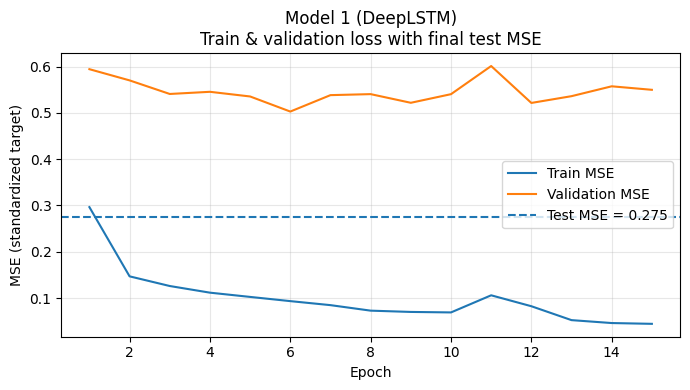

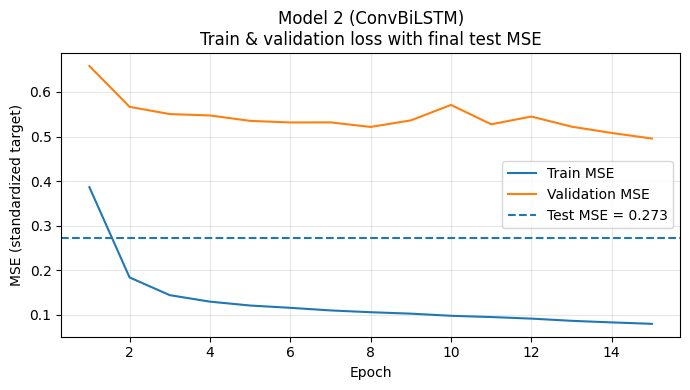

In [ ]:
import matplotlib.pyplot as plt

# Plots show the training and validation MSE over epochs for the best parameter
# combination for each model. This illustrates the learning behaviour and makes
# it easy to compare with the final test MSE shown as a horizontal line.

# Model 1 – DeepLSTM
plt.figure(figsize=(7, 4))
plt.plot(epochs1, best1_hist["train"], label="Train MSE")
plt.plot(epochs1, best1_hist["valid"], label="Validation MSE")
plt.axhline(
    y=m1_test_mse,
    linestyle="--",
    linewidth=1.5,
    label=f"Test MSE = {m1_test_mse:.3f}"
)
plt.xlabel("Epoch")
plt.ylabel("MSE (standardized target)")
plt.title("Model 1 (DeepLSTM)\nTrain & validation loss with final test MSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Model 2 – ConvBiLSTM
plt.figure(figsize=(7, 4))
plt.plot(epochs2, best2_hist["train"], label="Train MSE")
plt.plot(epochs2, best2_hist["valid"], label="Validation MSE")
plt.axhline(
    y=m2_test_mse,
    linestyle="--",
    linewidth=1.5,
    label=f"Test MSE = {m2_test_mse:.3f}"
)
plt.xlabel("Epoch")
plt.ylabel("MSE (standardized target)")
plt.title("Model 2 (ConvBiLSTM)\nTrain & validation loss with final test MSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Selected road_id with most samples in the test set: Frederikssundsvej


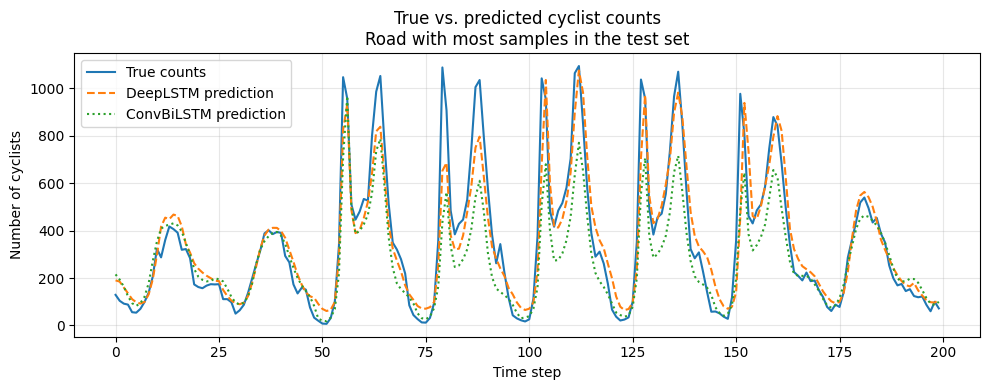

In [17]:
# Line plot comparing true and predicted cyclist counts over time for one example
# road in the test set. The road with the highest number of samples is used.
# This gives a clearer and reliable comparison, since the models have more
# historical observations for this road. The plot only shows a small snippet
# (200 time steps ≈ a bit more than 8 days) to keep it readable.

# Count how many samples each road_id has in the test set
unique_roads, counts = np.unique(roads1, return_counts=True)

# Select the road_id with the highest count
example_road = unique_roads[np.argmax(counts)]
road_name = [name for name, idx in road_id.items() if idx == example_road][0]
print(f"Selected road_id with most samples in the test set: {road_name}")

# Build masks selecting all samples belonging to this road
mask1 = (roads1 == example_road)
mask2 = (roads2 == example_road)

# Extract standardized true and predicted values for this road
y_true_road  = y1_true[mask1]
y_pred1_road = y1_pred[mask1]
y_pred2_road = y2_pred[mask2]

# For plotting readability, restrict to the first N (200) time steps
N = 200
y_true_road  = y_true_road[:N]
y_pred1_road = y_pred1_road[:N]
y_pred2_road = y_pred2_road[:N]

# Models were trained on standardized targets; inverse transform to obtain
# the actual number of cyclists
y_true_real  = y_scaler.inverse_transform(y_true_road.reshape(-1, 1)).ravel()
y_pred1_real = y_scaler.inverse_transform(y_pred1_road.reshape(-1, 1)).ravel()
y_pred2_real = y_scaler.inverse_transform(y_pred2_road.reshape(-1, 1)).ravel()

# Plot: True vs predicted cyclist counts over time
plt.figure(figsize=(10, 4))

# True observed cyclist counts
plt.plot(y_true_real, label="True counts", linewidth=1.5)

# Predicted counts from DeepLSTM (Model 1)
plt.plot(y_pred1_real, label="DeepLSTM prediction", linestyle="--")

# Predicted counts from ConvBiLSTM (Model 2)
plt.plot(y_pred2_real, label="ConvBiLSTM prediction", linestyle=":")

plt.xlabel("Time step")
plt.ylabel("Number of cyclists")
plt.title("True vs. predicted cyclist counts\nRoad with most samples in the test set")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
